<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center>  Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. 

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1EbjK7-hF-Gepi6RH-K5I2XeiYGRoY0LNDx03QmLu9Xo). 

## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = r'C:\Users\Дмитрий Мошкин\Documents\GitHub\moshkin\MFTI_Yandex_DA_specialisation\6 course\capstone_user_identification'

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):

    site_freqs_dict = pd.read_pickle(site_freq_path)
    site_ids_dict = {key: val[0] for key, val in site_freqs_dict.items()}
    rows_list = []
    target = []

    for filepath in glob(os.path.join(path_to_csv_files, '*.csv')):
        timestamps = []
        sites = []
        userid = int(filepath[-8:-4].lstrip('0')) 

        with open(filepath, 'r') as f:
            f.readline()
            for line in f:
                time, site = line.strip().split(',')
                timestamps.append(pd.Timestamp(time))  # format='%Y-%m-%d %H:%M:%S'
                sites.append(site)

        pos = 0
        while pos < len(sites):
            rows_list.append({'site' + str(key+1): 
                              val for key, val in enumerate(sites[pos:pos+session_length])}) 
            rows_list[-1].update({'time_diff' + str(key):  
                                  val for key, val in enumerate(timestamps[pos:pos+session_length])})
            target.append(userid)
            pos += window_size
    

    sessions = pd.DataFrame(rows_list, columns=['site' + str(i+1) for i in range(session_length)]
                            + ['time_diff' + str(i) for i in range(session_length)])
    sessions.iloc[:,:session_length] = \
                    sessions.iloc[:,:session_length].apply(lambda x: x.map(site_ids_dict, na_action='ignore'))
    min_time = sessions.iloc[:,session_length:session_length*2].min(axis=1)
    timespan = (sessions.iloc[:,session_length:session_length*2].max(axis=1) - 
                min_time).dt.seconds
    for i in range(session_length*2-1, session_length, -1):
        sessions.iloc[:,i] = (sessions.iloc[:,i] - sessions.iloc[:,i-1]).dt.seconds
    sessions['session_timespan'] = timespan
    sessions['#unique_sites'] = sessions.iloc[:,:session_length].nunique(axis=1).astype(np.int8)  
                                # this is time consuming operation
    sessions['start_hour'] = min_time.dt.hour.astype(np.int8)
    sessions['day_of_week'] = min_time.dt.dayofweek.astype(np.int8)
    sessions['target'] = np.array(target).astype(np.int16)
    sessions.drop('time_diff0', axis=1, inplace=True)
    sessions.fillna(0, inplace = True)
    sessions.iloc[:, :session_length] = sessions.iloc[:, :session_length].astype(np.int16)
    sessions.iloc[:, session_length:-4] = sessions.iloc[:, session_length:-4].astype(np.int32)
    
    return sessions

**Проверим функцию на игрушечном примере.**

In [4]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

In [5]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      3      2      2      9      2      1      7      5      8      10   
1      3      1      1      1      0      0      0      0      0       0   
2      3      2      6      6      2      0      0      0      0       0   
3      4      1      2      1      2      1      1      5     11       4   
4      4      1      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [6]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                  feature_names=feature_names, session_length=10)

Wall time: 1.81 s


In [7]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0    192    574    133      3    133    133      3    133    203     133   
1    415    193    674    254    133     31    393   3305    217      55   
2     55      3     55     55      5    293    415    333    897      55   
3    473   3306    473     55     55     55     55    937    199     123   
4    342     55      5   3307    258    211   3308   2086    675    2086   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week  target  
0           8            4      31  
1           8            4      31  
2           8            4      31  
3           8            4      31  
4           8            4      31

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [7]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '150users'), 
                      site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
                      feature_names=feature_names, session_length=10)

Wall time: 18.7 s


In [9]:
train_data_150users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137019 entries, 0 to 137018
Data columns (total 24 columns):
site1               137019 non-null int16
site2               137019 non-null int16
site3               137019 non-null int16
site4               137019 non-null int16
site5               137019 non-null int16
site6               137019 non-null int16
site7               137019 non-null int16
site8               137019 non-null int16
site9               137019 non-null int16
site10              137019 non-null int16
time_diff1          137019 non-null int32
time_diff2          137019 non-null int32
time_diff3          137019 non-null int32
time_diff4          137019 non-null int32
time_diff5          137019 non-null int32
time_diff6          137019 non-null int32
time_diff7          137019 non-null int32
time_diff8          137019 non-null int32
time_diff9          137019 non-null int32
session_timespan    137019 non-null int32
#unique_sites       137019 non-null int8
start_ho

**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [10]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [11]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

**<font color='red'>Вопрос 1. </font> Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [12]:
train_data_10users['session_timespan'].median()

37.0

**<font color='red'>Вопрос 2. </font> Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [13]:
train_data_10users['day_of_week'].median()

2.0

Это среда (дни недели нумеруются с нуля).

**<font color='red'>Вопрос 3. </font>Выведите медианный час начала сессии для сессий 150 пользователей.**

In [14]:
train_data_150users['start_hour'].median()

13.0

**<font color='red'>Вопрос 4. </font>Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [15]:
train_data_150users['#unique_sites'].median()

7.0

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [16]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [17]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

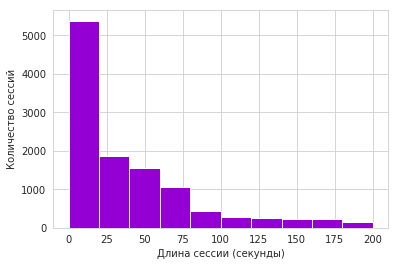

In [18]:
sns.set_style("whitegrid")  # сдалем графики покрасивее с помощью библиотеки seaborn

train_data_10users['session_timespan'].hist(range=(0,200), color='darkviolet');
plt.xlabel('Длина сессии (секунды)');
plt.ylabel('Количество сессий');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

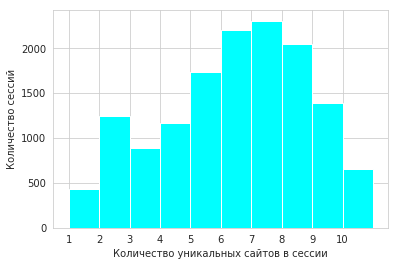

In [19]:
train_data_10users['#unique_sites'].hist(color='aqua',
                                         bins=np.arange(train_data_10users['#unique_sites'].min(), 
                                                     train_data_10users['#unique_sites'].max() + 2, 1));
plt.xlabel('Количество уникальных сайтов в сессии');
plt.ylabel('Количество сессий');
plt.gca().set_xticks(train_data_10users['#unique_sites'].unique());

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

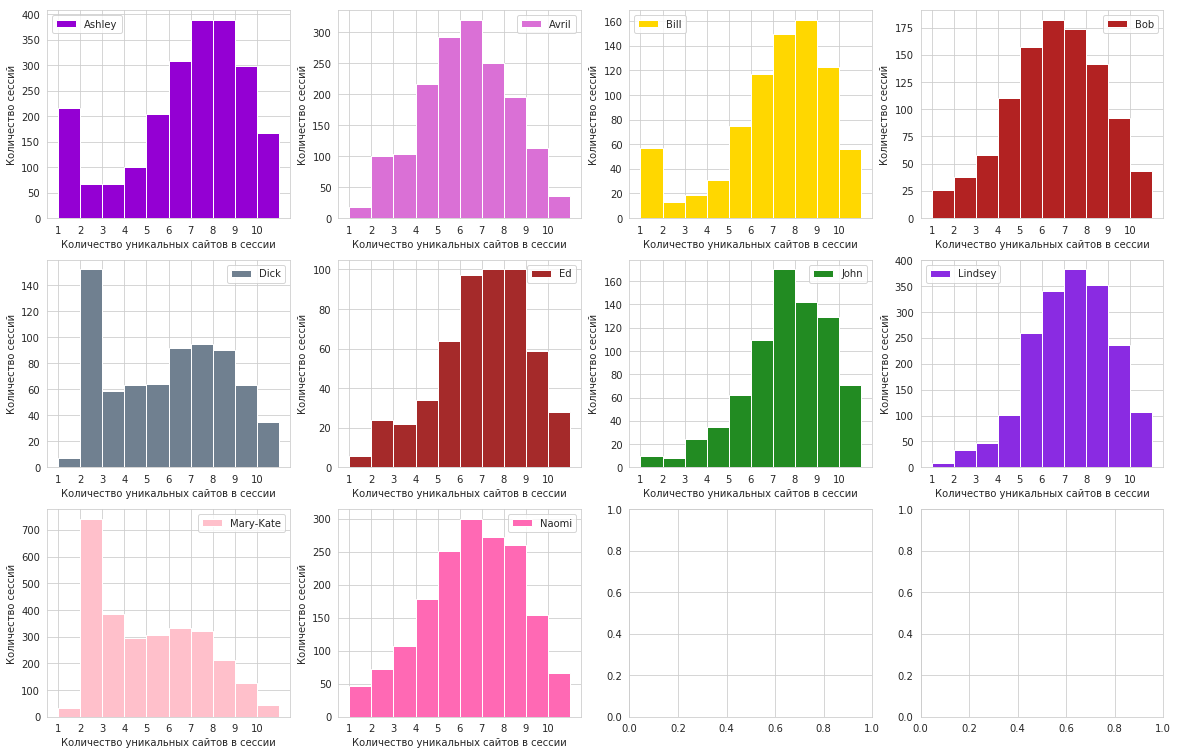

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 13))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    cur_axes = axes[idx // 4][idx % 4]
    sub_df['#unique_sites'].hist(ax = cur_axes, color=color_dic[user], 
                                 bins=np.arange(sub_df['#unique_sites'].min(), 
                                                     sub_df['#unique_sites'].max() + 2, 1));
    cur_axes.set_xlabel('Количество уникальных сайтов в сессии')
    cur_axes.set_ylabel('Количество сессий')
    cur_axes.legend([user])
    cur_axes.set_xticks(sub_df['#unique_sites'].unique());

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

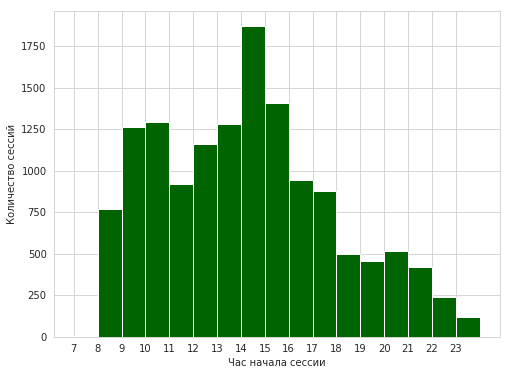

In [21]:
plt.figure(figsize=(8,6))
train_data_10users['start_hour'].hist(color='darkgreen', 
                                      bins=np.arange(train_data_10users['start_hour'].min(), 
                                                     train_data_10users['start_hour'].max() + 2, 1));
plt.xlabel('Час начала сессии');
plt.ylabel('Количество сессий');
from matplotlib.ticker import MaxNLocator
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # force integer ticks on x axis
plt.gca().set_xticks(train_data_10users['start_hour'].unique());

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

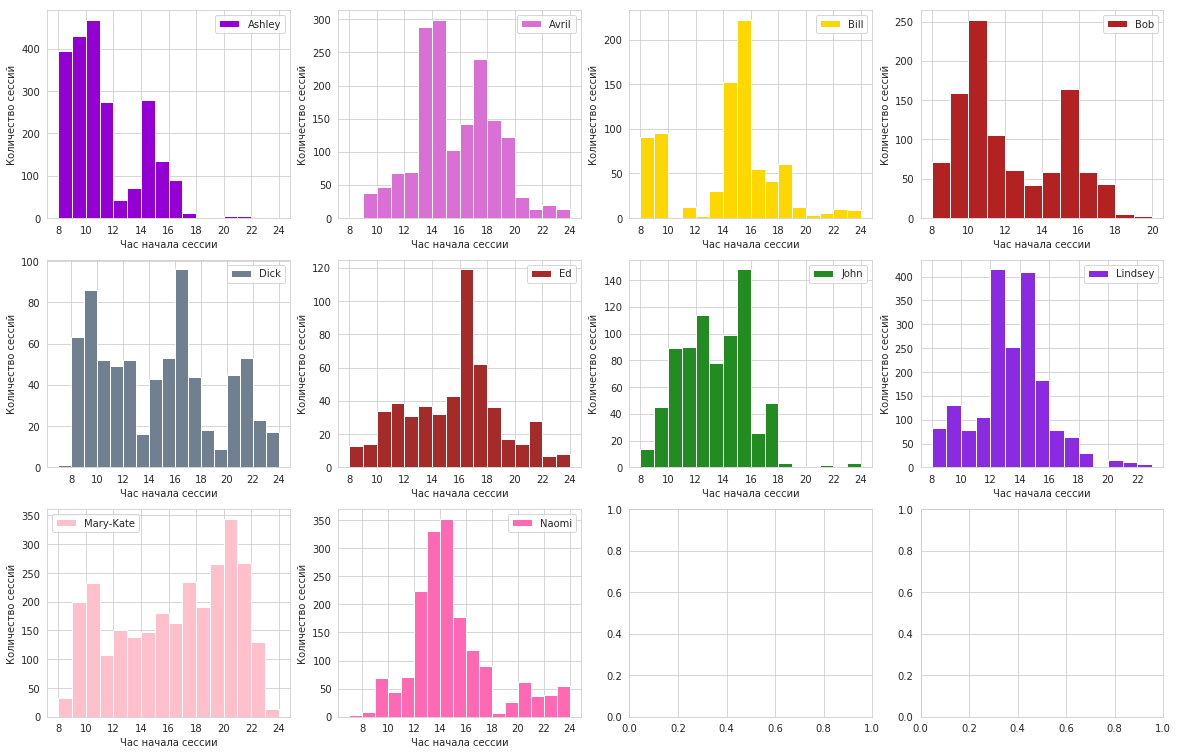

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 13))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    cur_axes = axes[idx // 4][idx % 4]
    sub_df['start_hour'].hist(ax = cur_axes, color=color_dic[user],
                             bins=np.arange(sub_df['start_hour'].min(), sub_df['start_hour'].max() + 2, 1))
    cur_axes.set_xlabel('Час начала сессии')
    cur_axes.set_ylabel('Количество сессий')
    cur_axes.legend([user])
    cur_axes.xaxis.set_major_locator(MaxNLocator(integer=True))  

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

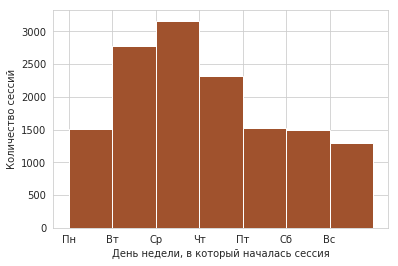

In [23]:
train_data_10users['day_of_week'].hist(color='sienna', bins=range(7+1));
plt.xlabel('День недели, в который началась сессия');
plt.ylabel('Количество сессий');
# Для наглядности в качестве меток оси абсцисс используем буквенные сокращения для дней недели:
plt.xticks(np.arange(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']);

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

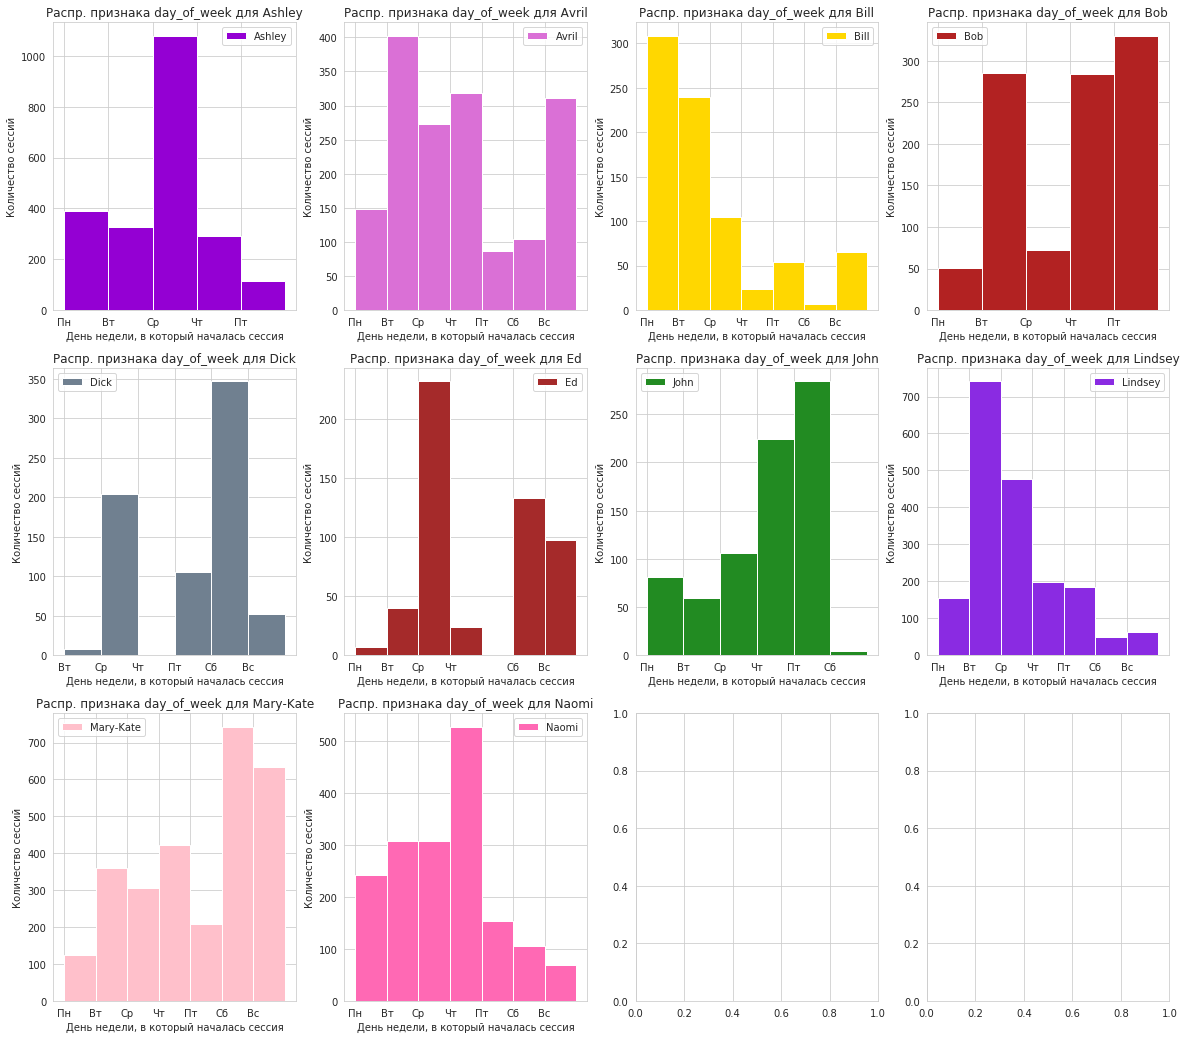

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 18))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'target')): 
    cur_axes = axes[idx // 4][idx % 4]
    sub_df['day_of_week'].hist(ax = cur_axes, color=color_dic[user], 
                               bins=np.arange(sub_df['day_of_week'].min(), sub_df['day_of_week'].max() + 2, 1))
    cur_axes.set_xlabel('День недели, в который началась сессия')
    cur_axes.set_ylabel('Количество сессий')
    cur_axes.legend([user])
    cur_axes.set_xticks(sub_df['day_of_week'].unique())
    cur_axes.set_xticklabels(pd.Series(sub_df['day_of_week'].unique()).map({0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 
                                                                            4: 'Пт', 5: 'Сб', 6: 'Вс'}).values)
    cur_axes.set_title('Распр. признака day_of_week для ' + user) # в этом задании требуется подписать НАЗВАНИЕ 
                                                                  # каждой из десяти гистограмм

*Отсутствие метки дня недели на оси абсцисс означает, что в этот день недели соответствующий user ни разу не начинал сессию. Так, на графике для Ashley отсутствуют метки 'Сб' и 'Вс', то есть у Ashley нет сессий, начинающихся в в субботу или воскресенье. А у Ed нет сессий, начинающихся в пятницу, так как на его графике метка 'Пт' отсутствует.*

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

''' ВАШЕ ОПИСАНИЕ ЗДЕСЬ '''

Отдельно по каждому пользователю мы строили графики для трех признаков – `#unique_sites`, `start_hour` и `day_of_week`. Их мы и будем анализировать.

Сначала рассмотрим признак `#unique_sites`. Его распределение у пользователей Bob, Ed, John, Lindsey и Naomi похоже на нормальное, но слегка скошено вправо: среднее значение этого признака у них попадает в диапазон от шести до семи.  У Bill и Ashley распределение отличается от вышеописанных тем, что имеет заметный пик слева - на значении признака, равном 1. У Avril распределение больше всего похоже на нормальное, так как является симметричным относительно центра. Наконец, у пользователей Dick и Mary-Kate распределение имеет ярко выраженный пик на значении признака, равном 2, и у них практически отсутствуют сессии, состоящие из одного уникального сайта (этим они сильно отличаются от Bill и Ashley). Также можно сказать, что больше всего данных для обучения у нас имеется по пользователям Mary-Kate и Ashley, а для пользователей Ed и Dick мы имеем меньше всего данных.  

Далее рассмотрим признак `start_hour`. Все пользователи, кроме Mary-Kate, Dick и Naomy, крайне редко начинают сессию в 22 или в 23 часа. В частности, Bob вообще не начинал сессию позже 20 часов. Dick и Naomy тоже относительно редко начинают сессию в 22 или в 23 часа, а вот Mary-Kate намного чаще остальных начинает сессию в 22 часа, но очень редко делает это в 23 часа. Далее, пользователь Ashley чаще всех остальных начинает сессию в 8 часов утра (он делал так около 400 раз), а кроме него высокую относительную долю сессий, начатых в 8 утра, имеют пользователи Bill и Dick. В 7 утра начинали сессию лишь два пользователя - Naomi и Dick.   
Наконец, можно выписать наиболее популярные часы для начала сессии по каждому пользователю. Avril и Naomi чаще всего начинают сессию в 13 или в 14 часов (и в целом распределения признака у них сильно похожи). Ashley – в промежутке с 8 до 11, Bill – в 14-15 часов, Bob - в 9-10 или в 15, Dick - в 9 или в 16, Ed - в 16-17, John - в 15, Lindsey - в 12 или 14, а Mary-Kate в промежутке 19-21. 

Перейдем к признаку `day_of_week`. Прежде всего, стоит отметить, что некоторые пользователи никогда не начинали сессию в определенные дни недели. Так, пользователи Ashley и Bob никогда не начинали сессию в субботу или воскресенье, Dick никогда не начинал сессию в понедельник и почти ни разу не начинал ее в четверг и во вторник, Ed никогда не начинал сессию в пятницу, а John - в воскресенье. Нисходящий тренд по количеству сессий наблюдается у Bill (от Пн к Вс) и Lindsey (от Вт к Вс, а в понедельник у нее начатых сессий относительно мало). Восходящий тренд по количеству сессий наблюдается у Mary-Kate (от Пн к Вс) и John (от Пн к Пт, в субботу он крайне редко начинал сессию, а в воскресенье вообще не начинал ее ни разу). Ashley и Ed подавляющее большинство раз начинали сессии в среду (Ashley - более 1000 раз), Dick - в субботу, а Naomi - в четверг. Наконец, Avril примерно с одинаковой частотой (300-400 раз) начинала сессию во вторник, среду, четверг или в воскресенье, и гораздо реже (с частотой около 100 раз) начинала сессию в понедельник, пятницу или субботу. 

График признака `session_timespan` строился сразу для всей выборки (без выделения отдельных пользователей). По нему можно сказать, что продолжительность сессии имеет нисходящий тренд, который ярко выражен в промежутке от 0 до 100 секунд, а далее нисходящий тренд уже гораздо более слабый. Выше было указано, что медианная продолжительность сессии составляет 37 секунд. Если на этом графике убрать верхнее ограничение на ось абсцисс, то станет заметным довольно большое число сильно удаленных выбросов в правой части графика.

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [25]:
site_freqs_dict = pd.read_pickle(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'))

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [26]:
top10_freqs = [val[1] for val in site_freqs_dict.values() if val[0] <=10] 
top10_sites = [key for key, val in site_freqs_dict.items() if val[0] <=10] 
print(top10_freqs)
print(top10_sites)

[8300, 7813, 5441, 4158, 4141, 3758, 3244, 3094, 2630, 2089]
['s.youtube.com', 'www.google.fr', 'www.google.com', 'mail.google.com', 'www.facebook.com', 'apis.google.com', 'r3---sn-gxo5uxg-jqbe.googlevideo.com', 'r1---sn-gxo5uxg-jqbe.googlevideo.com', 'plus.google.com', 'accounts.google.com']


**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

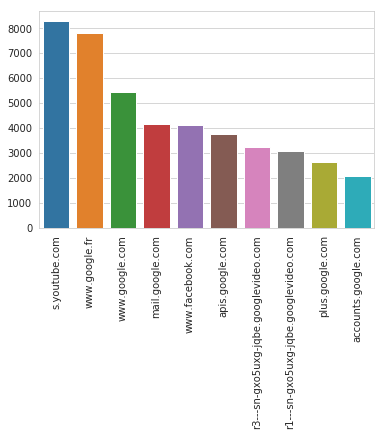

In [27]:
barplot = sns.barplot(x=top10_sites, y=top10_freqs)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90);

## Часть 3. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [28]:
def feature_engineering(path_to_csv_files, site_freq_path, session_length=10):
    window_size = 10
    
    # скопируем сюда тело функции prepare_train_set_with_fe, определенной ранее
    site_freqs_dict = pd.read_pickle(site_freq_path)
    site_ids_dict = {key: val[0] for key, val in site_freqs_dict.items()}
    rows_list = []
    target = []

    for filepath in glob(os.path.join(path_to_csv_files, '*.csv')):
        timestamps = []
        sites = []
        userid = int(filepath[-8:-4].lstrip('0')) 

        with open(filepath, 'r') as f:
            f.readline()
            for line in f:
                time, site = line.strip().split(',')
                timestamps.append(pd.Timestamp(time))  # format='%Y-%m-%d %H:%M:%S'
                sites.append(site)

        pos = 0
        while pos < len(sites):
            rows_list.append({'site' + str(key+1): 
                              val for key, val in enumerate(sites[pos:pos+session_length])}) 
            rows_list[-1].update({'time_diff' + str(key):  
                                  val for key, val in enumerate(timestamps[pos:pos+session_length])})
            target.append(userid)
            pos += window_size
    

    sessions = pd.DataFrame(rows_list, columns=['site' + str(i+1) for i in range(session_length)]
                            + ['time_diff' + str(i) for i in range(session_length)])
    sessions.iloc[:,:session_length] = \
                    sessions.iloc[:,:session_length].apply(lambda x: x.map(site_ids_dict, na_action='ignore'))
    min_time = sessions.iloc[:,session_length:session_length*2].min(axis=1)
    timespan = (sessions.iloc[:,session_length:session_length*2].max(axis=1) - 
                min_time).dt.seconds
    for i in range(session_length*2-1, session_length, -1):
        sessions.iloc[:,i] = (sessions.iloc[:,i] - sessions.iloc[:,i-1]).dt.seconds
    sessions['session_timespan'] = timespan
    sessions['#unique_sites'] = sessions.iloc[:,:session_length].nunique(axis=1).astype(np.int8)  
                                # this is time consuming operation
    sessions['start_hour'] = min_time.dt.hour.astype(np.int8)
    sessions['day_of_week'] = min_time.dt.dayofweek.astype(np.int8)
    sessions['target'] = np.array(target).astype(np.int16)
    sessions.drop('time_diff0', axis=1, inplace=True)
    sessions.fillna(0, inplace = True)
    sessions.iloc[:, :session_length] = sessions.iloc[:, :session_length].astype(np.int16)
    sessions.iloc[:, session_length:-4] = sessions.iloc[:, session_length:-4].astype(np.int32)
    
    
    ##### НОВЫЕ признаки #####
    
    # год начала сессии
    sessions['start_year'] = min_time.dt.year.astype(np.int16)  
    # месяц начала сессии
    sessions['start_month'] = min_time.dt.month.astype(np.int8)  
    # число сайтов в сессии, входящих в топ-20 наиболее популярных сайтов
    sessions['top20_count'] = sessions.iloc[:,:session_length].isin(range(1,21)).sum(axis=1).astype(np.int8)
    # индикатор "длинной" сессии (продолжительностью более 30 сек)
    sessions['long_session'] = (sessions['session_timespan'] > 30).astype(np.int8)
    # число сайтов в сессии, у которых временная метка совпадает с временной меткой предыдущего сайта 
    # из этой же сессии с точностью до секунды (то есть число сайтов, для которых time_diff = 0)
    sessions['num_sites'] = (sessions.iloc[:,session_length:session_length*2-1] == 0).sum(axis=1).astype(np.int8)

    return sessions[['start_year', 'start_month', 'top20_count', 'long_session', 'num_sites', 'target']]

In [29]:
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), 
                                           os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'))

In [30]:
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'), 
                                            os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl')) 

**10. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [31]:
new_features_10users['target'] = new_features_10users['target'].map(id_name_dict)

In [32]:
# вспомогательная функция для построения гистограмм
def plot_hists(feature, xlabel):
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 13))

    for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'target')): 
        cur_axes = axes[idx // 4][idx % 4]
        sub_df[feature].hist(ax=cur_axes, color=color_dic[user],
                             bins=np.arange(sub_df[feature].min(), sub_df[feature].max() + 2, 1));
        cur_axes.set_xlabel(xlabel)
        cur_axes.set_ylabel('Количество сессий')
        cur_axes.legend([user])
        cur_axes.set_xticks(sub_df[feature].unique());

### Признак 'start_year'

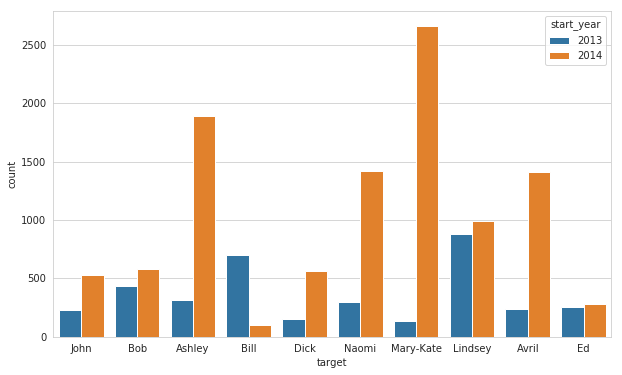

In [33]:
plt.figure(figsize=(10,6))
sns.countplot(x='target', hue='start_year', data=new_features_10users);

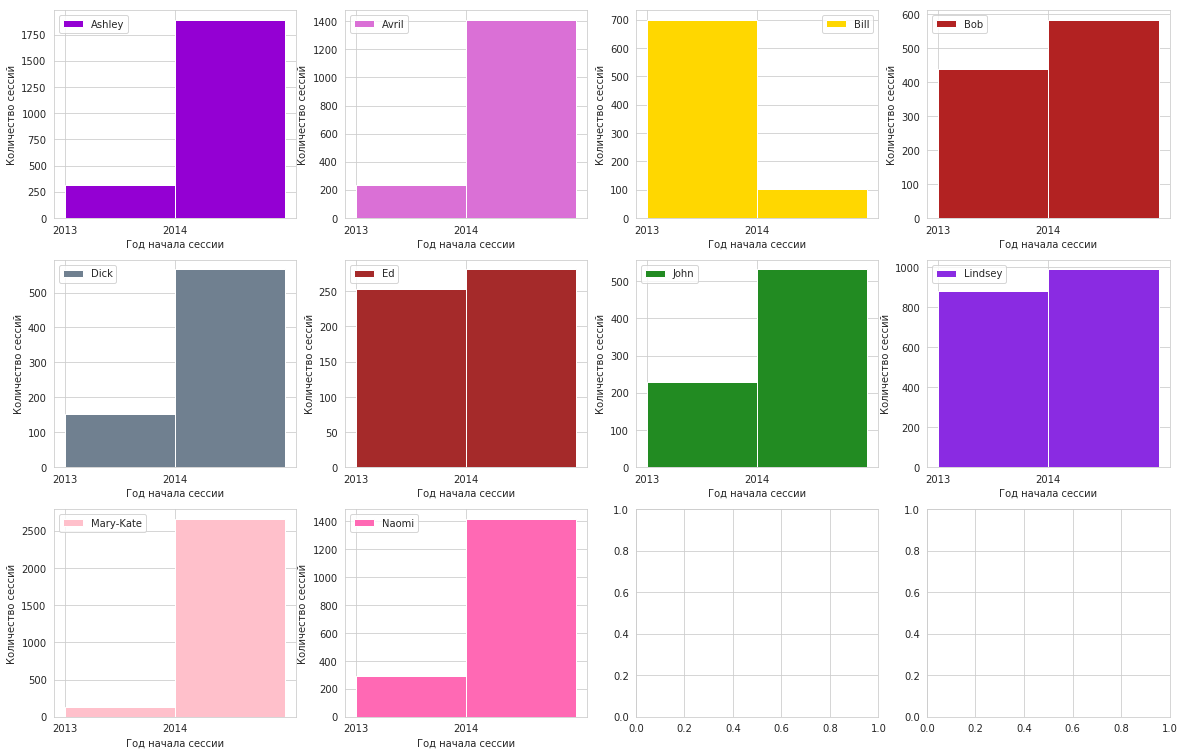

In [34]:
plot_hists('start_year', 'Год начала сессии')

Пользователи Ed, Lindsey и Bob имеют примерно одинаковое количество сессий в 2013 и 2014 годах (наблюдается лишь небольшое увеличение в 2014 году - правый столбец графика чуть выше левого). У Ashley, Avril, Dick, John, Mary-Kate и Naomi наблюдается значительное увеличение количества сессий в 2014 г. по сравнению с 2013 г. (у Mary-Kate - более чем в 10 раз). Только для пользователя Bill наблюдается противоположная картина - у него количество сессий, проведенных в 2013 году значительно больше, чем в 2014 году (то есть для этого пользователя характерен спад активности с течением времени). 

### Признак 'start_month'

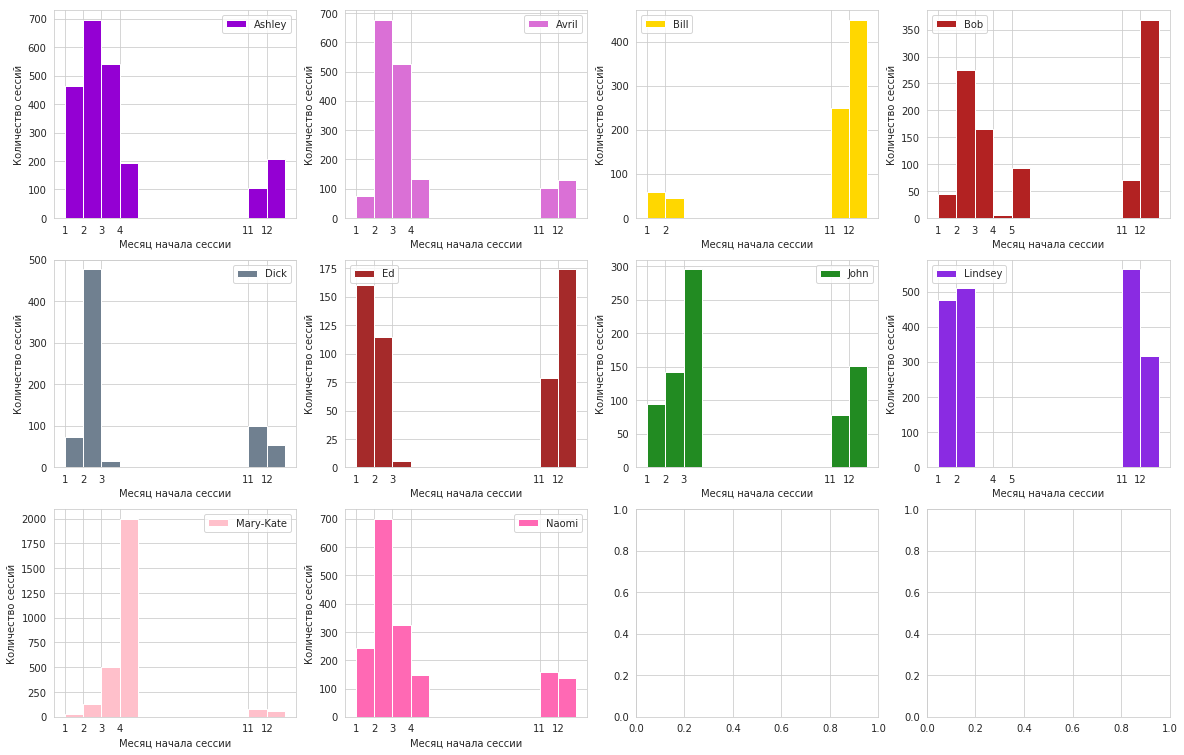

In [35]:
plot_hists('start_month', 'Месяц начала сессии')

*Отсутствие метки номера месяца на оси абсцисс означает, что в этот месяц соответствующий user ни разу не начинал сессию.*

Здесь прежде всего нужно отметить, что у нас нет данных о сессиях пользователей в промежутке с июня по октябрь (включительно). В мае заметную активность проявлял только Bob, у Lindsey была очень слабая активность в мае, а все остальные пользователи вообще не начинали в мае ни одной сессии. Однако абсолютно все пользователи имеют сессии, начатые в январе, феврале, ноябре и декабре.  
Далее можно выделить три группы пользователей: тех, кто преимущественно начинал сессии в промежутке с января по апрель (Ashley, Avril, Dick, John, Mary-Kate и Naomi), затем тех, кто преимущественно начинал сессии в ноябре и декабре (Bill) и, наконец, тех, у кого количество сессий в первой половине года примерно равно количеству сессий в ноябре-декабре (Bob, Ed, Lindsey).   

### Признак 'top20_count'

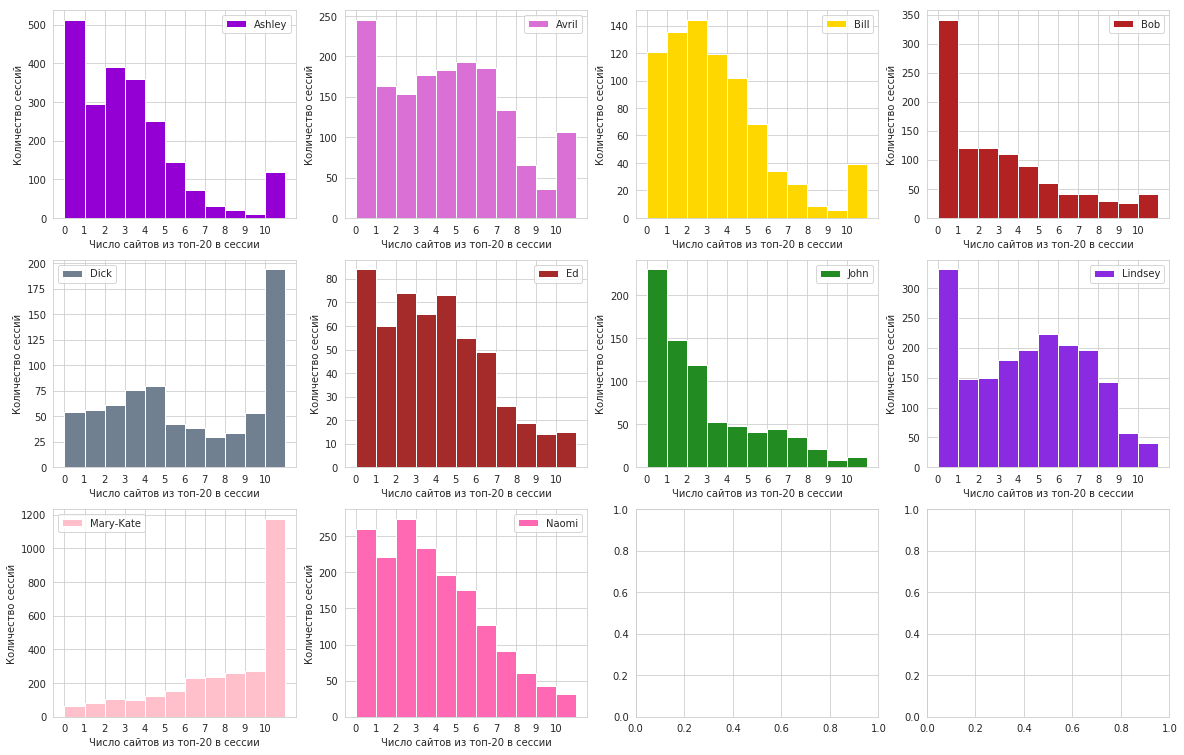

In [36]:
plot_hists('top20_count', 'Число сайтов из топ-20 в сессии')

Строго восходящий тренд наблюдается лишь на графике для пользователя Mary-Kate. Сессии у пользователей Mary-Kate и Dick чаще всего целиком состоят из сайтов, взятых из списка топ-20 (20 наиболее популярных сайтов). У пользователей Naomi, Ed, John и Bob графики полностью противоположные - они имеют в целом нисходящий тренд и довольно часто сессии этих пользователей целиком состоят из сайтов, не входящих в список топ-20 (на их графиках наблюдается пик в значении ноль). У Ashley, Avril и Bill нисходящий тренд наблюдается не везде и имеется небольшой пик на значении 10. У Lindsey, за исключением пика в нуле, график чем-то напоминает нормальное распределение с тяжелым хвостом слева.

### Признак 'long_session'

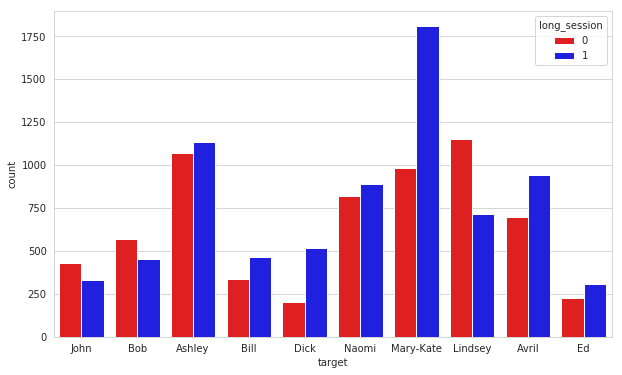

In [37]:
plt.figure(figsize=(10,6))
sns.countplot(x='target', hue='long_session', data=new_features_10users, palette=['red', 'blue']);

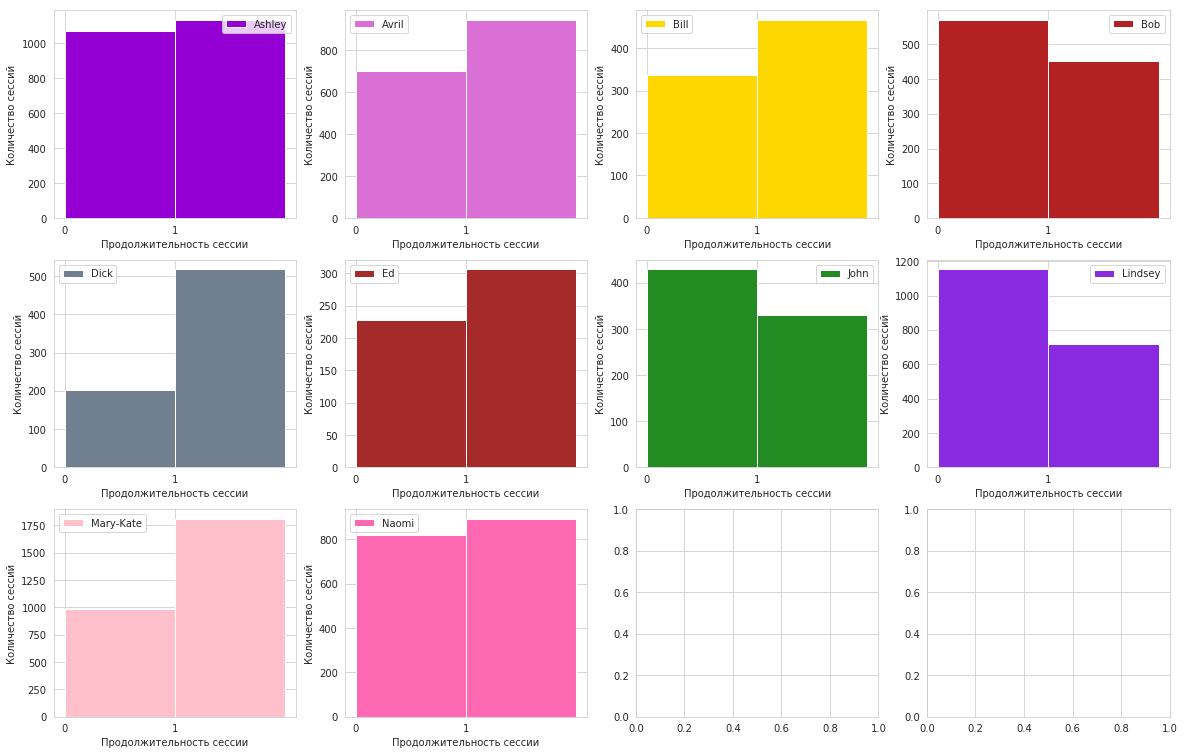

In [38]:
plot_hists('long_session', 'Продолжительность сессии')

Длинной сессией (значение 1 по оси абсцисс), как было указано выше, мы считаем сессию продолжительностью более 30 секунд. В противном случае сессию считаем короткой (значение 0 по оси абсцисс).  
У пользователей Mary-Kate и Dick количество длинных сессий примерно в два раза превосходит количество коротких сессий, а у Lindsey наоборот - количество длинных сессий почти в два раза меньше количества коротких сессий. У Ed, Avril и Bill количество длинных сессий примерно на 20% больше количества коротких сессий, а у John и Bob - наоборот меньше примерно на 15-20%.     
Наконец, количество длинных и коротких сессий практически совпадает между собой у пользователей Naomi и Ashley.  

### Признак 'num_sites'

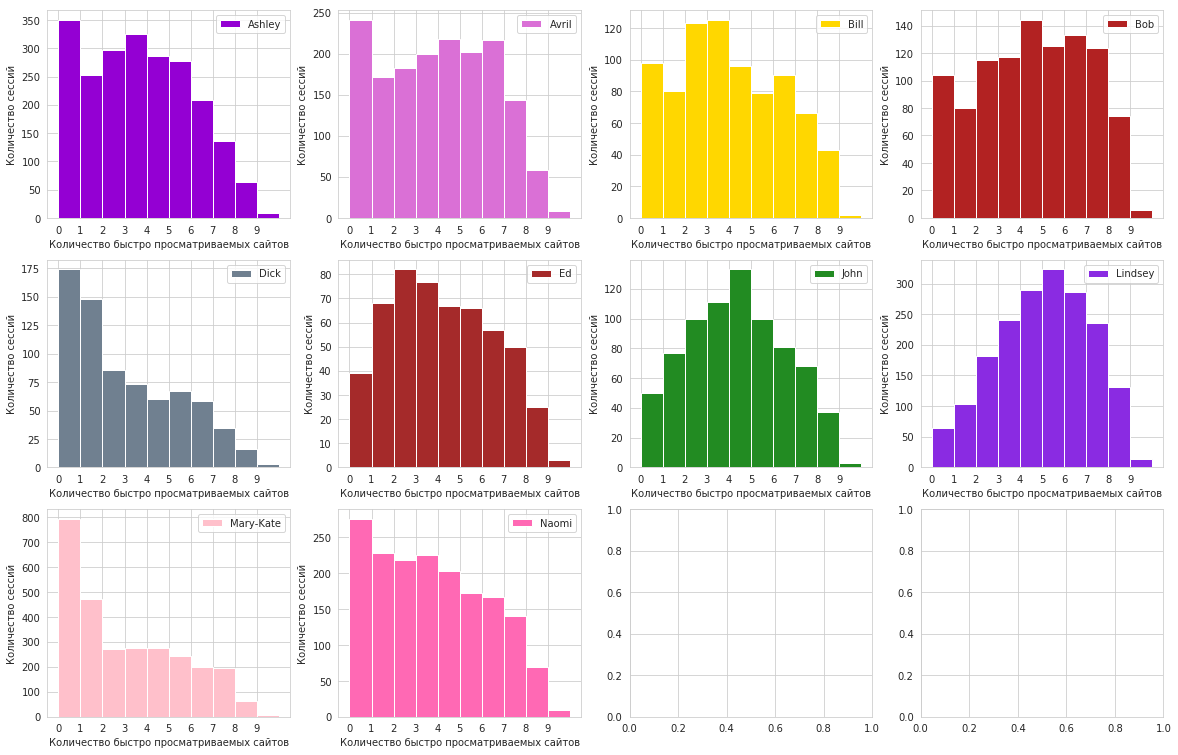

In [39]:
plot_hists('num_sites', 'Количество быстро просматриваемых сайтов')

*Метки для десяти сайтов на оси абсцисс здесь нет, так как мы не знаем момент времени, в который пользователь ушел с последнего сайта в сессии (нам были даны только временные метки, соответствующие моментам захода на сайты)*

У всех пользователей крайне мало сессий, в которых 9 из 10 сайтов являются быстро просматриваемыми.
У Mary-Kate, Dick и Naomi на графиках наблюдается довольно выраженный нисходящий тренд. У John и Lindsey распределение рассматриваемого признака весьма похоже на нормальное. У других пользователей на графиках нет ярко выраженного общего тренда, однако заметно резкое снижение количества сессий для значений 8 и 9 по оси абсцисс.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [40]:
selected_features_10users = pd.concat([train_data_10users[['session_timespan', 'start_hour', 'day_of_week']], 
                                      new_features_10users.iloc[:,:-1]], axis=1) 
selected_features_150users = pd.concat([train_data_150users[['session_timespan', 'start_hour', 'day_of_week']], 
                                      new_features_150users.iloc[:,:-1]], axis=1)  

In [41]:
selected_features_150users.head()

session_timespan  start_hour  day_of_week  start_year  start_month  \
0                57           8            4        2013           11   
1              1618           8            4        2013           11   
2              2010           8            4        2013           11   
3              2006           9            4        2013           11   
4                10           9            4        2013           11   

   top20_count  long_session  num_sites  
0            8             1          3  
1            1             1          3  
2            6             1          1  
3            4             1          3  
4            3             0          4

In [42]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

### Критерии оценки работы (только для Peer Review в специализации):
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 